# Data Proccesing

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!kaggle datasets download -d ryanpartridge01/wild-edible-plants

100% 1.70G/1.70G [00:47<00:00, 31.5MB/s]
100% 1.70G/1.70G [00:47<00:00, 38.3MB/s]


In [5]:
!unzip wild-edible-plants.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/resized/garlic_mustard/garlic_mustard246.jpg  
  inflating: dataset/resized/garlic_mustard/garlic_mustard247.jpg  
  inflating: dataset/resized/garlic_mustard/garlic_mustard248.jpg  
  inflating: dataset/resized/garlic_mustard/garlic_mustard249.jpg  
  inflating: dataset/resized/garlic_mustard/garlic_mustard25.jpg  
  inflating: dataset/resized/garlic_mustard/garlic_mustard250.jpg  
  inflating: dataset/resized/garlic_mustard/garlic_mustard251.jpg  
  inflating: dataset/resized/garlic_mustard/garlic_mustard252.jpg  
  inflating: dataset/resized/garlic_mustard/garlic_mustard253.jpg  
  inflating: dataset/resized/garlic_mustard/garlic_mustard254.jpg  
  inflating: dataset/resized/garlic_mustard/garlic_mustard255.jpg  
  inflating: dataset/resized/garlic_mustard/garlic_mustard256.jpg  
  inflating: dataset/resized/garlic_mustard/garlic_mustard257.jpg  
  inflating: dataset/resized/garlic_mustard/garlic_mustard258.jpg 

In [6]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
data_dir = 'dataset/resized/'

In [8]:
os.getcwd()

'/content'

In [9]:
from preproccesing import preprocess_image

In [10]:
# creating testing set

X_test = []
y_test = []

for folder in sorted(os.listdir(data_dir)):
  images_dir = data_dir + str(folder)
  for num,image in enumerate(os.listdir(images_dir)):
    image_dir = images_dir + '/' + str(image)
    if num < 40:
      y_test.append(folder)
      X_test.append(preprocess_image(image_dir))
      os.remove(image_dir)
    else:
      break

In [11]:
X_test = np.array(X_test)
y_test = np.array(y_test)

In [12]:
print(X_test.shape)
print(y_test.shape)

(1400, 299, 299, 3)
(1400,)


In [13]:
new_size = (299,299)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.20
)

valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.20
)

train_data = train_datagen.flow_from_directory(data_dir, target_size = new_size, class_mode = 'categorical',
                                              subset='training')
val_data = valid_datagen.flow_from_directory(data_dir, target_size = new_size, class_mode = 'categorical',
                                            subset='validation')

Found 12112 images belonging to 35 classes.
Found 3014 images belonging to 35 classes.


# Building Model

In [14]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import SGD,RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense,Flatten

height = 299
width = 299
dim = 3

model_inception = InceptionV3(input_shape=(height, width, dim),
                              include_top= False,
                              weights='imagenet')
model_inception.trainable = False

87924736/87910968 [==============================] - 0s 0us/step


In [15]:
model =   Sequential([Input(shape=(height, width, dim)),
                     model_inception,
                     Flatten(),
                     Dense(256,activation='relu'),
                     Dense(35,activation='softmax')])

In [16]:
from keras.metrics import Precision, Recall

learning_rate = 0.01
epochs = 200

model.compile(optimizer=SGD(learning_rate=learning_rate,nesterov=False),
              loss ='categorical_crossentropy', metrics=['acc', Precision(), Recall()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 256)               33554688  
                                                                 
 dense_1 (Dense)             (None, 35)                8995      
                                                                 
Total params: 55,366,467
Trainable params: 33,563,683
Non-trainable params: 21,802,784
_________________________________________________________________


In [17]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10,restore_best_weights=True)

In [18]:
history = model.fit(train_data,
    validation_data=val_data,
    epochs=epochs,
    callbacks=es)

Epoch 1/200
379/379 [==============================] - 294s 738ms/step - loss: 2.2164 - acc: 0.4259 - precision: 0.7064 - recall: 0.2601 - val_loss: 1.2492 - val_acc: 0.6443 - val_precision: 0.7828 - val_recall: 0.5226
Epoch 2/200
379/379 [==============================] - 277s 730ms/step - loss: 1.1418 - acc: 0.6548 - precision: 0.7970 - recall: 0.5441 - val_loss: 1.0951 - val_acc: 0.6828 - val_precision: 0.7741 - val_recall: 0.6072
Epoch 3/200
379/379 [==============================] - 276s 728ms/step - loss: 0.9777 - acc: 0.6979 - precision: 0.8106 - recall: 0.6141 - val_loss: 0.9127 - val_acc: 0.7283 - val_precision: 0.8043 - val_recall: 0.6639
Epoch 4/200
379/379 [==============================] - 276s 729ms/step - loss: 0.8478 - acc: 0.7433 - precision: 0.8374 - recall: 0.6685 - val_loss: 0.8558 - val_acc: 0.7555 - val_precision: 0.8264 - val_recall: 0.7027
Epoch 5/200
379/379 [==============================] - 275s 726ms/step - loss: 0.7871 - acc: 0.7589 - precision: 0.8419 - re

# Model Evaluation

In [19]:
def plot_learning_curves(history,epochs):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10,7))
    plt.plot(range(epochs), acc, 'b', label='training accuracy')
    plt.plot(range(epochs), val_acc, 'r', label='validation accuracy')

    plt.plot(range(epochs), loss, 'g', label='training loss')
    plt.plot(range(epochs), val_loss, 'orange', label='validation loss')
    plt.legend()
    plt.grid(True)

    plt.show()

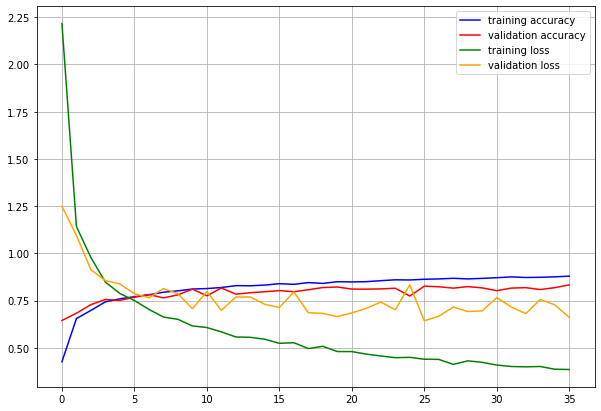

In [20]:
plot_learning_curves(history,len(history.history['acc']))

In [21]:
y_true = y_test

predictions = history.model.predict(X_test)

y_pred = np.argmax(predictions, axis=-1)

In [26]:
val_data.class_indices['alfalfa']

0

In [30]:
with open('classes_dict', 'w') as file:
  file.write(str(val_data.class_indices))

In [56]:
y_pred

array([ 0,  0,  0, ..., 34, 17, 34])

In [59]:
def class_int(predictions: list, class_dictionary: dict):
  new_lst = []
  for prediction in predictions:
    cl_int = [x[1] for x in class_dictionary.items() if x[0] == prediction]
    new_lst.append(cl_int)
  return np.array(new_lst)

In [62]:
y_true = class_int(y_true, val_data.class_indices)

In [63]:
print(y_true[:5])
print(y_pred[:5])

[[0]
 [0]
 [0]
 [0]
 [0]]
[ 0  0  0  2 34]


In [64]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true,y_pred))

0.8164285714285714


In [65]:
from sklearn.metrics import classification_report

print(classification_report(y_true=y_true,y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.62      0.57      0.60        40
           1       0.68      0.68      0.68        40
           2       0.84      0.80      0.82        40
           3       0.75      0.68      0.71        40
           4       0.90      0.88      0.89        40
           5       0.97      0.90      0.94        40
           6       0.79      0.82      0.80        40
           7       0.89      1.00      0.94        40
           8       0.87      0.65      0.74        40
           9       0.93      1.00      0.96        40
          10       0.75      0.68      0.71        40
          11       0.85      0.85      0.85        40
          12       0.70      0.80      0.74        40
          13       0.76      0.78      0.77        40
          14       0.95      0.95      0.95        40
          15       0.81      0.88      0.84        40
          16       0.71      0.90      0.79        40
          17       0.72    

# Exporting Model with pickle

In [66]:
import pickle

with open('plant_model','wb') as f:
    pickle.dump(history.model,f)

INFO:tensorflow:Assets written to: ram://876ec956-7cfc-42ea-bd61-a7af5408fdbe/assets
